# K-Means Clustering with OpenMP and MPI

### Implement the k-means clustering algorithm in OpenMP/MPI, trying to maximize the performance (reduce the execution time) by carefully exploiting the resources within one computing node with multiple processing cores (OpenMP) and across computing nodes (MPI).

Optional: implement the same algorithm in Apache Flink and compare the performance of the two implementations (processing time and scalability) under various workloads.

-------------------------------------------------------------------------------------------------------------------------

In [1]:
import csv
import random
import sys

import numpy
import os  # We need this module
import matplotlib.pyplot as plt
import seaborn as sns;
from sklearn.datasets.samples_generator import make_blobs
sns.set()  # for plot styling

#Samples
N_SAMPLES = 100000

# Get path of the current dir, then use it to create paths:
CURRENT_DIR = os.path.dirname("__file__")
file_path = os.path.join(CURRENT_DIR, 'dataset_display/dataset.csv')
initial_dataset_path = os.path.join(CURRENT_DIR, 'dataset_display/results_10K/initialdataset.csv')
initial_centroids_path = os.path.join(CURRENT_DIR, 'dataset_display/results_10K/initialcentroids.csv')
new_dataset_path = os.path.join(CURRENT_DIR, 'dataset_display/newdataset.csv')
new_centroids_path = os.path.join(CURRENT_DIR, 'dataset_display/newcentroids.csv')
objfun_path = os.path.join(CURRENT_DIR, 'dataset_display/results_10K/objfun.csv')
exectimes_path = os.path.join(CURRENT_DIR, 'dataset_display/results_10K/exectimes.csv')
results_path = os.path.join(CURRENT_DIR, 'dataset_display/results_10K/results.csv')

fig_width = 12
fig_height = 10

# Initial Dataset

## Display the points in the Initial Dataset:

We have a Dataset of 100000 points, randomly generated by a custom Python script. These points are already somehow divided in clusters so that we can more easily test the K-Means Clustering algorithm.

In [2]:
print('X,Y')
with open(initial_dataset_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for i,row in enumerate(reader):
        print(row['X'], row['Y'])
        if(i >= 10):
            break
            
print("Total points: %s" % format(N_SAMPLES,'d'))

X,Y
5.392970 -9.131667
-6.623092 8.340944
-2.025470 -6.686408
-0.286500 1.709346
-1.270230 -8.275856
0.099879 1.514994
4.731501 -7.893067
-1.254859 -7.296748
0.010068 1.667364
4.776079 -8.596875
-7.439105 8.802632
Total points: 100000


## And now we plot the initial dataset:

By plotting the Dataset, we can see that is indeed form by 4 clusters easily observable. We'll later test the K-Means Clustering algorithm and see if it can also individuate the clusters.

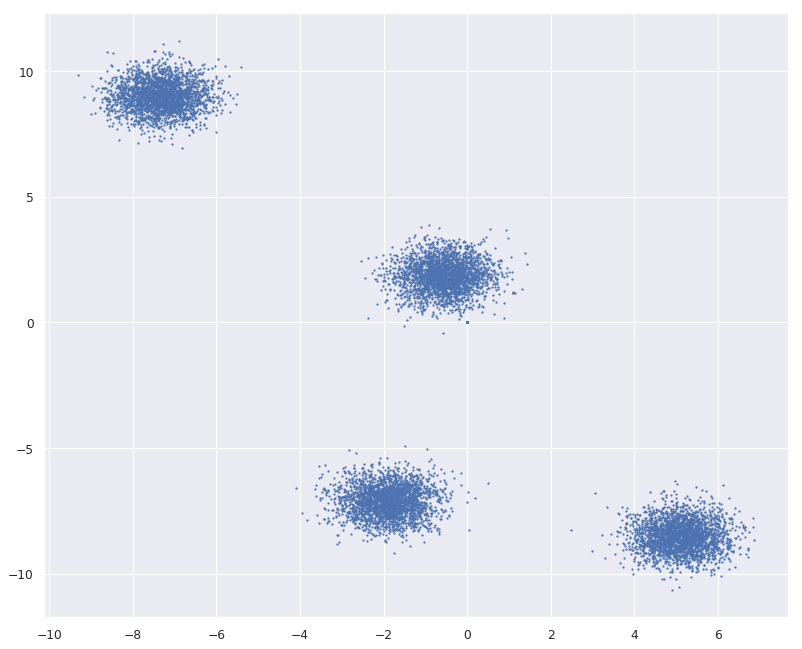

In [3]:
x = numpy.zeros(N_SAMPLES)
y = numpy.zeros(N_SAMPLES)

#Read the dataset from the CVS file
with open(initial_dataset_path) as csvfile:
    reader = csv.DictReader(csvfile)
    i = 0
    for row in reader:
        x[i] = row['X']
        y[i] = row['Y']
        #print(x[i], y[i])
        i=i+1

#Plot the read dataset
plt.figure(figsize=(fig_width, fig_height), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(x[:], y[:], s=1)
plt.show()

## Initial Centroids

The Initial Centroids are randomply placed at runtime, however a centroids will be recreated if it is too close to another centroid. The initial placing of the centroids is of fundamental importance to the result of the K-Means Clustering algorithm execution on a given dataset. Lets print the centroids: 

In [4]:
print('Cluster,X,Y')
centroids = 0
with open(initial_centroids_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        print(centroids, row['X'], row['Y'])
        centroids = centroids + 1
print("Total centroids: %d" % centroids)

Cluster,X,Y
0 1.693458 4.355714
1 -2.306542 3.355714
2 0.693458 9.355714
3 -4.306542 -5.644286
4 1.693458 5.355714
5 -3.306542 0.355714
6 -1.306542 -8.644286
7 -7.306542 -8.644286
8 -2.306542 9.355714
9 -4.306542 3.355714
Total centroids: 10


And now we plot them:

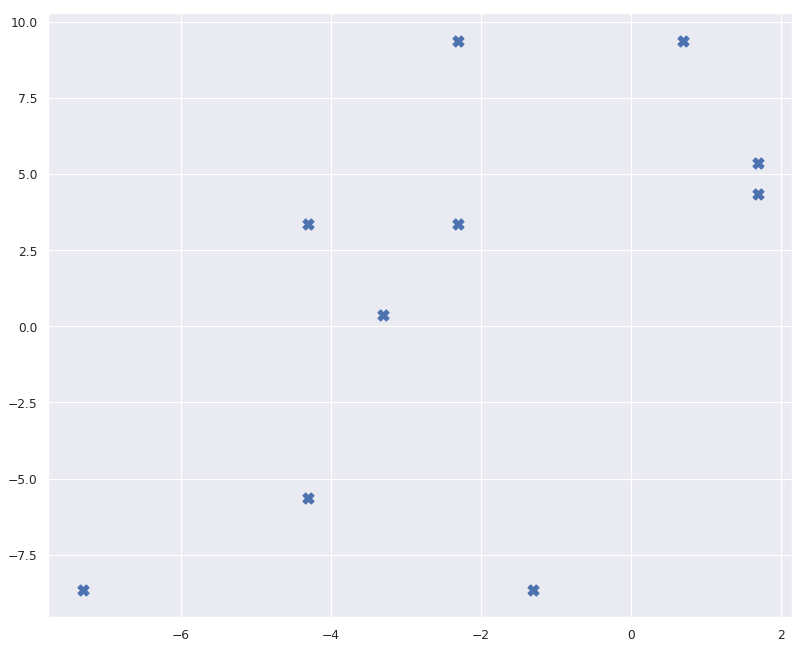

In [5]:
x = numpy.zeros(centroids)
y = numpy.zeros(centroids)

#Read the dataset from the CVS file
with open(initial_centroids_path) as csvfile:
    reader = csv.DictReader(csvfile)
    i = 0
    for row in reader:
        x[i] = row['X']
        y[i] = row['Y']
        #print(x[i], y[i])
        i=i+1

#Plot the read dataset
plt.figure(figsize=(fig_width, fig_height), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(x[:], y[:], marker="X", s=100)
plt.show()

# Plotting both Dataset and Centroids

 We've run the K-Means Clustering Algorithm on the initial dataset and got new centroids each associated to a cluster. So we now plot the resulting clusters separated by a random color and their centroids:

In [6]:
def random_color():
    return numpy.random.rand(3,)

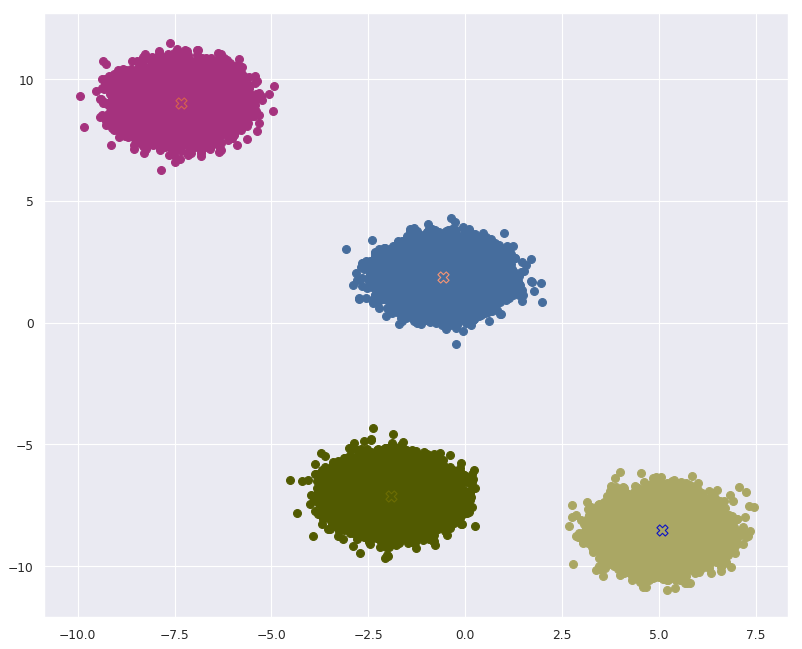

In [7]:
x = numpy.zeros(N_SAMPLES)
y = numpy.zeros(N_SAMPLES)
c = numpy.zeros(N_SAMPLES)
cx = list()
cy = list()

plt.figure(figsize=(fig_width, fig_height), dpi= 80, facecolor='w', edgecolor='k')

# Read the new centroids from the CVS file
with open(new_centroids_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        cx.append(float(row['X']))
        cy.append(float(row['Y']))

# Read the new dataset from the CVS file
with open(new_dataset_path) as csvfile:
    reader = csv.DictReader(csvfile)
    i = 0
    for row in reader:
        x[i] = row['X']
        y[i] = row['Y']
        c[i] = row['Cluster']
        # print(x[i], y[i])
        i = i + 1

minK = c.min()
maxK = c.max()
k = (int)(maxK - minK + 1)

# plot the points for each cluster with a different color
for i in range(k):
    x2 = list()
    y2 = list()

    for j in range(N_SAMPLES):
        if c[j] == i:
            x2.append(x[j])
            y2.append(y[j])

    # Plot the read dataset
    color1 = random_color()
    color2 = random_color()
    plt.scatter(x2[:], y2[:], c=color1, s=50)
    plt.scatter(cx[i], cy[i], c=color1, marker="X", edgecolor=color2, s=100)
plt.show()

## Running Modes: Normal, OpenMP, MPI

The program written in C actually executes three different versions of the K-Means Clustering Algorithm. They run sequentially one at a time, but they use the same initial dataset and the same random pair of initial centroids. The initial position of the centroids is of vital importance to the result of the execution so is important that all three versions use the same set of centroids so that we can have a meaningful comparison in performance.
All three versions will produce the same result and same objective function value, but they will have different execution times. We've set the maximum number of cores for the OpenMP verision (4 on this PC), and 4 parallel processes for the MPI Version. As expected the OpenMP and MPI version perform much better that the sequential version, here are the result on this dataset:

In [8]:
print('Execution Times:\n')
t = numpy.zeros(4)
with open(exectimes_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for i,row in enumerate(reader):
        t[i] = row['Time']
            
print('Normal Execution --> ' + str(t[0]*1000) + 'ms')
print('OpenMP Execution --> ' + str(t[1]*1000) + 'ms')
print('MPI Execution    --> ' + str(t[2]*1000) + 'ms')
print('MPI + OpenMP Execution    --> ' + str(t[3]*1000) + 'ms')

Execution Times:

Normal Execution --> 300.10900000000004ms
OpenMP Execution --> 26.671ms
MPI Execution    --> 1176.875ms
MPI + OpenMP Execution    --> 880.817ms


While the value of the Objective Function is:

In [9]:
objfun = numpy.zeros(4)
with open(objfun_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for i,row in enumerate(reader):
        objfun[i] = row['ObjFun']
            
print('ObjectiveFunction value --> ' + str(objfun[0]))

ObjectiveFunction value --> 5395.179688


------------------------------------------
------------------------------------------

# Results

### Cumulative Execution Results

By running a bach script we were able cumulate a large quantity of execution results (more than 1000 executions). For consistency we've run all three different versions of the K-Means Clustering Algorithm sequentially one at a time on the same initial dataset and the same random pair of initial centroids. That way the results of each execution can be compered with the executions of the other two versions of the algorithm. For each executions we've stored the number of centroids, the execution mode(algorithm version), the execution time and the obj function result.

### Relation between number of centroids and obj function value
Let's average the executions results in the large dataset described above and plot the relation between the number of centroids and the obj function value. The execution were made with a number of centroids between 1 and 10.

Rows in the results file: 805


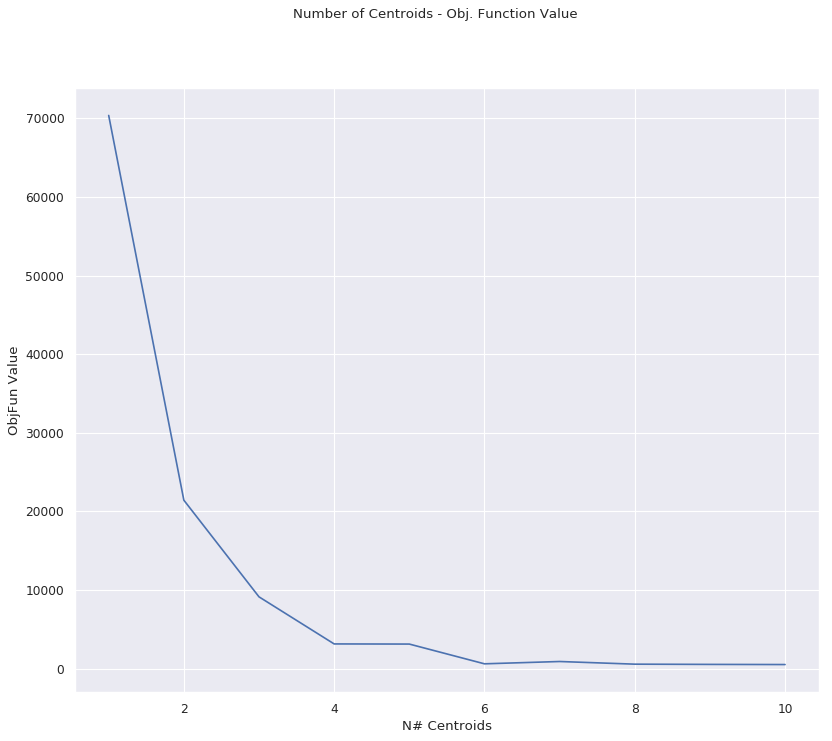

In [14]:
row_count = 0
with open(results_path) as csvfile:
    row_count = sum(1 for line in csvfile)
print ("Rows in the results file: " + str(row_count))
EXECUTIONS = int((row_count - 1)/4)  

n_c      = numpy.zeros(EXECUTIONS)
openmp_c = numpy.zeros(EXECUTIONS)
mpi_c    = numpy.zeros(EXECUTIONS)
mpi_mp_c = numpy.zeros(EXECUTIONS)

n_t      = numpy.zeros(EXECUTIONS)
openmp_t = numpy.zeros(EXECUTIONS)
mpi_t    = numpy.zeros(EXECUTIONS)
mpi_mp_t = numpy.zeros(EXECUTIONS)

n_of      = numpy.zeros(EXECUTIONS)
openmp_of = numpy.zeros(EXECUTIONS)
mpi_of    = numpy.zeros(EXECUTIONS)
mpi_mp_of = numpy.zeros(EXECUTIONS)

# Read the new centroids from the CVS file
with open(results_path) as csvfile:
    reader = csv.DictReader(csvfile)
    i1,i2,i3,i4=0,0,0,0
    for i,row in enumerate(reader):
        mode = int(row['Mode'])
        #print(mode + "-" + str(i))
        
        #Normal Execution
        if mode == 0:
            n_c[i1]  = float(row['K'])
            n_t[i1]  = float(row['Time'])
            n_of[i1] = float(row['ObjFun'])
            i1 = i1 + 1
        #OpenMP Execution
        elif mode == 1:
            openmp_c[i2]  = float(row['K'])
            openmp_t[i2]  = float(row['Time'])
            openmp_of[i2] = float(row['ObjFun'])
            i2 = i2 + 1
        #MPI Execution
        elif mode == 2:
            mpi_c[i3]  = float(row['K'])
            mpi_t[i3]  = float(row['Time'])
            mpi_of[i3] = float(row['ObjFun'])
            i3 = i3 + 1
        #MPI + OpenMP Execution
        elif mode == 3:
            mpi_c[i4]  = float(row['K'])
            mpi_t[i4]  = float(row['Time'])
            mpi_of[i4] = float(row['ObjFun'])
            i4 = i4 + 1

x_val = numpy.zeros(10)
y_val = numpy.zeros(10)

#Calc the mean values
for i in range(0,10):
    x_val[i] = i + 1
    #print(str(i))
    
    #Iterate all the executions for each centroid number
    for j in range(EXECUTIONS):
        if n_c[j] == i+1:
            y_val[i] = y_val[i] + n_of[j]
        
    #Obj Function values mean
    y_val[i] = y_val[i] / EXECUTIONS
    #print(str(y_val[i]))
    
#Plot the between number of centroids and obj function value
plt.figure(figsize=(fig_width, fig_height), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x_val,y_val)
plt.suptitle('Number of Centroids - Obj. Function Value')
plt.xlabel('N# Centroids')
plt.ylabel('ObjFun Value')
plt.show()

### Resulting plot analisys
Given the Plot above we can observe the way that the Obj. Function Values(Y-Axis) change based on the Number of Centroids(X-Asis) used. And we can clearly notice that the Knee value is equal to "4". It's the Knee value because the successive numbers of centroids don't have an Obj. Function Value that decreases greatly. That means that the distances in between the data points and the centroids for each cluster don't decrease much after the value of 4 centroids used. So just by observing the above plot and chosing the knee value we can conlude that the Dataset is composed of 4 clusters witch is correct since we are the ones that generated the datased divided in four clusters in the first place.

### Relation between Number of Centroids and the Execution Time
Let's now again average the executions results in the large dataset described above and plot the relation between the number of centroids and the Execution times. The execution were made with a number of centroids between 1 and 10.

Let's also compare the results for each of the three execution modes: Normal, OpenMP, MPI

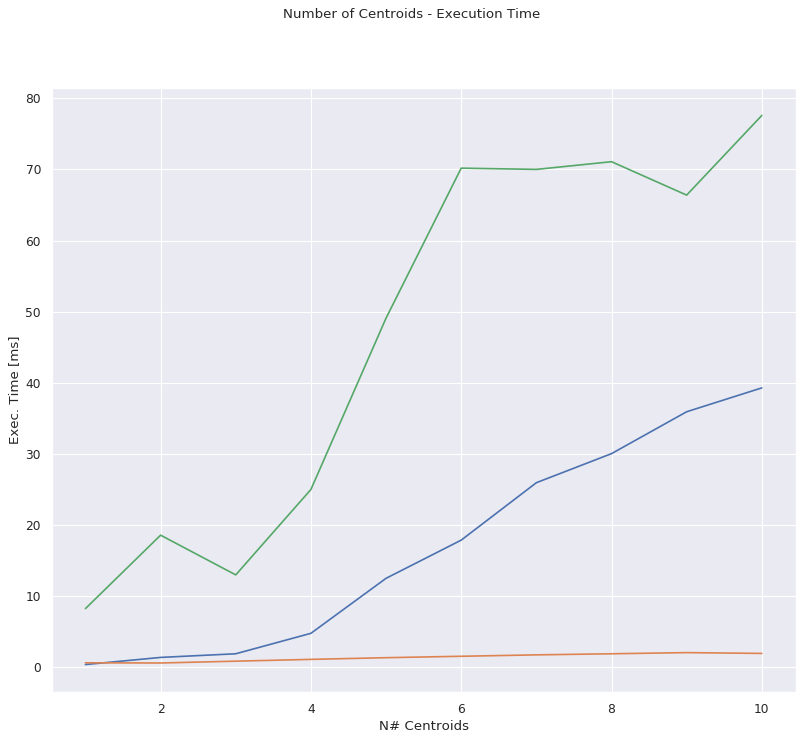

In [15]:
x_valc       = numpy.zeros(10)    # Centroids
y_val_n_et   = numpy.zeros(10)    # Normal Execution Time
y_val_mp_et  = numpy.zeros(10)    # OpenMP Execution Time
y_val_mpi_et = numpy.zeros(10)    # MPI Execution Time

#Calc the mean values
for i in range(0,10):
    x_valc[i] = i + 1
    #print(str(i))
    
    #Iterate all the executions for each centroid number
    for j in range(EXECUTIONS):
        # Normal Execution
        if n_c[j] == i+1:
            y_val_n_et[i] = y_val_n_et[i] + n_t[j]
        
        # OpenMP Execution
        if openmp_c[j] == i+1:
            y_val_mp_et[i] = y_val_mp_et[i] + openmp_t[j]
            
        # MPI Execution
        if openmp_c[j] == i+1:
            y_val_mpi_et[i] = y_val_mpi_et[i] + mpi_t[j]
        
    #Execution Time values mean
    y_val_n_et[i]   = (y_val_n_et[i] / EXECUTIONS) * 1000
    y_val_mp_et[i]  = (y_val_mp_et[i] / EXECUTIONS) * 1000
    y_val_mpi_et[i] = (y_val_mpi_et[i] / EXECUTIONS) * 1000
    #print("n " + str(y_val_n_et[i]))
    #print("mp " + str(y_val_mp_et[i]))
    #print("mpi " + str(y_val_mpi_et[i]))
    
#Plot the between number of centroids and obj function value
plt.figure(figsize=(fig_width, fig_height), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x_valc,y_val_n_et)
plt.suptitle('Number of Centroids - Execution Time')
plt.xlabel('N# Centroids')
plt.ylabel('Exec. Time [ms]')
plt.plot(x_valc,y_val_mp_et)
plt.plot(x_valc,y_val_mpi_et)
plt.show()

### Resulting plot analisys
On the above plot we can observe the Execution Times(Y-Axis) for each execution mode base on the number of centroids(X-Axis). And it's imeadiatly clear just by a glance that both OpenMP(Orange Line) and MPI Modes(Green line) greatly outperform the single-core and single-process Normal Mode(Blue line). 

However we can also see that the OpenMP Mode(Orange Line) also outperforms the MPI Mode(Green line) not only Normal Mode. This is probably due to all the message exchange between the processes in MPI Mode that are neccessary for managing the paralellization of the operations and due to the broadcasting/gathering of the data to/from the processes. 

Finally we remind the reader that the above plot is made by avareging the behavior of a large number of executions each with a different initial random centroids placement. And it has beed noticed that if the inital placement of the centroids is a good one, then the MPI Mode performs as well as the OpenMP Mode does, so by egaging in a more sophisticated algorithms for centroids placement we could have comparble results for the OpenMP and MPI Modes.